## Lab 7. Topic 3. Deep Neural Networks
## Autoencoders

We will use material from the book "Hands-On Machine Learning with Scikit-Learn and TensorFlow. Concepts, Tools, and Techniques to Build Intelligent Systems" by Aurélien Géron. http://shop.oreilly.com/product/0636920052289.do that it is recommended as Bibliography of the course.


In [1]:
# We start by importing the python libraries required to solve the problems

import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler


# Tensorflow library used for implementation of the DNNs
import tensorflow as tf


# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display
from IPython.display import Image
from IPython.display import SVG


In [2]:
# This function set the seeds of the tensorflow function
# to make this notebook's output stable across runs

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

We will use different functions for showing the MNIST and fashion-MNIST images

In [3]:
# Displays a single image
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
# Displays multiple images   
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")
    

In [5]:
# Below is the code to convert the svg files that contain chinese characters to png files and to create numpy array
# containing all the examples

#import cairosvg

#png = []
#for svg_file in glob.glob("svgs/*.svg"):
#    png_file = svg_file.replace(".svg", ".png")
#    cairosvg.svg2png(url=svg_file, write_to=png_file, parent_width=28, parent_height=28)
#    #print(png_file)
#    png.append(np.asarray(misc.imread(png_file)[:,:,3]).reshape((28*28,1)))    

#im = np.asarray(png)
#print(im.shape)
#np.save('chinese_characters',im)

## Reading the MNIST dataset

We will the MNIST dataset and we download it in case it has not been downloaded before.


Remember that in this supervised classification problem there are 28x28 images containing written digits. The images can be of 10 possible labels, one for each digit.


In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [5]:
# The train and test sets are defined 
#X_train = mnist.train.images
#X_test = mnist.test.images
#y_train = mnist.train.labels.astype("int")
#y_test = mnist.test.labels.astype("int")

#  Multi-layer perceptron with tensorflow
 
We start by exploring some of the main components of DNNs. These are: Number of layers, Activation Functions, and Loss Functions. As discussed in the introductory less to DNNs, the way these components are selected determines the DNN behavior and should be related to the problem to solve. Another component that influences the behavior of the network is the optimization method used to search in the space of weights. We have covered this component in previous laboratories. 

In the following steps, we create a MLP with the following characteristics:


- It has 2 hidden layers
- The first layer has 300 hidden units, the second 100 hidden units
- Since it will be applied to the classification of MNIST images, the number of inputs will be 28*28=748


In [6]:
# Parameters that define the MLP

n_inputs = 28*28  
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10


The tensorflow variables that will contain the train data and the classes are declared.
Remember that in tensorflow, variables are first declared, later initialized.

In [7]:
# Function reset_graph() set the seeds of the tensorflow function
# to make this notebook's output stable across runs

reset_graph()

# Variables are declared, notice that the shape of X is only partially defined
# with the number of inputs, but not the number of instances 
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

 The following function is essential since it defines the structure of the network layer. The student should be able to understand every single line of this function. 
 
 The neuron_layer function receives as input:   <font color="red">X</font>, i.e., the values that the neuron layer processes (they can be original inputs X of the problem or the output of the previous layer). Another input parameter is  <font color="red">n_neurons</font>, the number of neurons that the layer comprises. It also receives a  <font color="red">scope name</font>  that serves to identify the layer by defining a "scope". The use of scopes is a useful functionality of tensorflow that allows to encapsulate the variables within program domains and later its visualization using tensorboard (another tool that we will study later in the course). Finally it receives the type of  <font color="red">activation function</font>. 


In [9]:
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        # Number of inputs
        n_inputs = int(X.get_shape()[1])
        
        # This value is computed to randomly initialize the weights
        stddev = 2 / np.sqrt(n_inputs)
        
        # Weigths can be initialized in different ways
        # Here they are randomly initialized from a Normal distribution (mean=0,std as computed before)
        # Notice that weights are organized in a matrix (tensor) and its number is n_inputs*n_neurons
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # The variable that will contain the weights is W
        W = tf.Variable(init, name="kernel")
        
        # The variable that will contain the bias is b  
        # and is initialized to zero
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # As in the perceptron what the neurons do is multiply the weights by 
        # the input
        Z = tf.matmul(X, W) + b
        
        # What the activation function does is to "process" the result
        # of the multiplication of weights by inputs, and this is the output
        # of every neuron. 
        
        if activation is not None:
            return activation(Z)
        else:
            return Z

Once a generic layer has been defined we can specify the MLP architecture. 

In [10]:
# The scope name for this MLP is "dnn"
with tf.name_scope("dnn"):
    
    # The first hidden layer is defined using the RELU activation function
    # It will contain n_hidden1=300 hidden neurons and therefore output
    # 300 values    
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)

    # The second hidden layer is also defined using the RELU activation function
    # It will contain n_hidden2=100 hidden neurons and therefore output
    # 100 values    
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    
    # The output layer does not use any activation function
    # it will output n_outputs=10 values since there are 10 classes in MNIST
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

The other essential component of the DNN is the loss function which is the way in which we specify how to measure the quality of the network in the process of learning its parameters (weights and bias). 
There are many loss functions, for instance, for regression problems we have previously considered the mean squared error. 

The sparse_softmax_cross_entropy implements the cross-entropy function: $H(p,q) = - \sum_x p(x) log(x)$ where $p$ is the true distribution and $q$ is the approximation given by the network.

In this case, the probability distribution $q$ that the network produces is based on the $10$ output values of the network output layer. The values are transfered into probabilities in the following way:  $q(NN(x)=d) = \frac{e^{f_d(x)}}{\sum_{i=1}^{10} e^{f_i(x)}}$


In [11]:
# scope name of the loss function is "loss"
with tf.name_scope("loss"):
    
    # The Loss function is defined. It outputs a loss value for each x
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    
    # The total loss is mean of the loss values 
    loss = tf.reduce_mean(xentropy, name="loss")

We need to define an optimization algorithm to optimize the weights of the network. This is done in the following step.

In [12]:
learning_rate = 0.01

with tf.name_scope("train"):
    # The plain GradientDescentOptimizer is chosen
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Although we will use the softmax cross-entropy to optimize the weights, it is possible to define other accuracy measures to evaluate the quality of the network. Here the accuracy is defined. 

In [13]:

with tf.name_scope("eval"):
    # A prediction is correct if it is among the k=1 most probable
    # classes predicted by the NN. Since k=1, it is only correct
    # if the prediction coincides with the true class.
    correct = tf.nn.in_top_k(logits, y, 1)
    
    # The accuracy is the mean of correct predictions
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Finally, we initialize the computation graph, the number of epochs and the batch size for learning the network.

In [15]:
# Initialization of the computation graph
init = tf.global_variables_initializer()

# tensorflow allows to define a saver to store the model after learning
saver = tf.train.Saver()

# Number of epochs
n_epochs = 15

# Size of the batch used to update the gradient
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            
            #Function next_batch automatically select the batch
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            
            # Weights are learned using the current batch            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        # Accuracies are computed in the training and validation sets    
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: mnist.validation.images,
                                            y: mnist.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")



0 Train accuracy: 0.9 Val accuracy: 0.9174
1 Train accuracy: 0.9 Val accuracy: 0.9384
2 Train accuracy: 0.94 Val accuracy: 0.943
3 Train accuracy: 0.92 Val accuracy: 0.9514
4 Train accuracy: 0.94 Val accuracy: 0.956
5 Train accuracy: 0.98 Val accuracy: 0.959
6 Train accuracy: 0.98 Val accuracy: 0.9608
7 Train accuracy: 0.96 Val accuracy: 0.9614
8 Train accuracy: 0.94 Val accuracy: 0.9634
9 Train accuracy: 0.94 Val accuracy: 0.965
10 Train accuracy: 0.98 Val accuracy: 0.9672
11 Train accuracy: 0.94 Val accuracy: 0.9678
12 Train accuracy: 0.96 Val accuracy: 0.9716
13 Train accuracy: 0.96 Val accuracy: 0.971
14 Train accuracy: 1.0 Val accuracy: 0.9716


## Activation functions

Before completing the first exercise, we analyze in more detail the activation functions. As mentioned before, activation function allow different transformation of the linear operation WX+b that the neuron does. They are also relevant for the gradient optimizer. In principle we would like functions whose derivative can support information about which is the direction of more improvement. 

In the following cell, the implementation of two common activation functions and a general definition of the derivative are presented. 

In [16]:
# Logistic function (sigma)
def logit(z):
    return 1 / (1 + np.exp(-z))

#Rectified Linear Unit  (ReLU)
def relu(z):
    return np.maximum(0, z)

# Derivative function
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

We visualize these functions together with their derivative. 

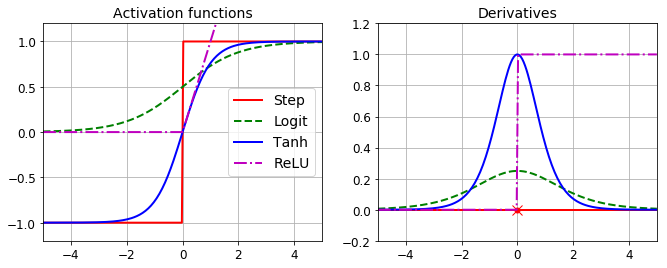

In [17]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=2, label="Step")
plt.plot(z, logit(z), "g--", linewidth=2, label="Logit")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(logit, z), "g--", linewidth=2, label="Logit")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

The figures also show the step function which is simply $sign(x)$. The step function is the one used by the original perceptron. Look in the graphs that the derivative of the step function is always zero. You can get more information about the activation functions in the slides of the introductory class to DNNs. 

## Exercise 1

Modify the two following cells to learn a MLP in tensorflow for the fashion dataset. The network should have the following characteristics.

- Three hidden layers of sizes: 200,100,25
- For the first two hidden layers use the ReLU activation function and for the third hidden layers use the tanh activation function
- Use the Momentum optimizer for the optimization of the parameters





We read the fashion dataset.

Extracting /tmp/data/fashion/train-images-idx3-ubyte.gz
Extracting /tmp/data/fashion/train-labels-idx1-ubyte.gz
Extracting /tmp/data/fashion/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/fashion/t10k-labels-idx1-ubyte.gz


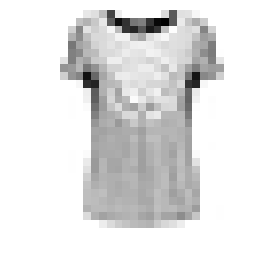

In [22]:
# Modify the name of the directory 'fashion_data' below and write the folder where you have this dataset. 
# In case you do not have it, you can download the four files from: 
# https://github.com/zalandoresearch/fashion-mnist
# The files  to download are:
# train-images-idx3-ubyte.gz
# train-labels-idx1-ubyte.gz
# t10k-images-idx3-ubyte.gz
# t10k-labels-idx1-ubyte.gz


from tensorflow.examples.tutorials.mnist import input_data
fashion = input_data.read_data_sets('/tmp/data/fashion')


# The train and test sets are defined 
X_train_fashion = fashion.train.images
X_test_fashion = fashion.test.images
y_train_fashion = fashion.train.labels.astype("int")
y_test_fashion = fashion.test.labels.astype("int")

# This line is to test you have uploaded the right dataset
plot_image(X_train_fashion[1,:])

In [32]:
# Parameters that define the MLP

n_inputs = 28*28  
n_hidden1 = 200
n_hidden2 = 100
n_hidden3 = 50
n_outputs = 10

reset_graph()

# Variables are declared, notice that the shape of X is only partially defined
# with the number of inputs, but not the number of instances 
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        # Number of inputs
        n_inputs = int(X.get_shape()[1])
        
        # This value is computed to randomly initialize the weights
        stddev = 2 / np.sqrt(n_inputs)
        
        # Weigths can be initialized in different ways
        # Here they are randomly initialized from a Normal distribution (mean=0,std as computed before)
        # Notice that weights are organized in a matrix (tensor) and its number is n_inputs*n_neurons
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # The variable that will contain the weights is W
        W = tf.Variable(init, name="kernel")
        
        # The variable that will contain the bias is b  
        # and is initialized to zero
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # As in the perceptron what the neurons do is multiply the weights by 
        # the input
        Z = tf.matmul(X, W) + b
        
        # What the activation function does is to "process" the result
        # of the multiplication of weights by inputs, and this is the output
        # of every neuron. 
        
        if activation is not None:
            return activation(Z)
        else:
            return Z
        
        
# The scope name for this MLP is "dnn"
with tf.name_scope("dnn"):
    
    h1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)

    h2 = neuron_layer(h1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    
    h3 = neuron_layer(h2, n_hidden2, name="hidden2", activation=tf.nn.tanh)
    
    
    # The output layer does not use any activation function
    # it will output n_outputs=10 values since there are 10 classes in MNIST
    logits = neuron_layer(h3, n_outputs, name="outputs")
    

# scope name of the loss function is "loss"
with tf.name_scope("loss"):
    
    # The Loss function is defined. It outputs a loss value for each x
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    
    # The total loss is mean of the loss values 
    loss = tf.reduce_mean(xentropy, name="loss")
    

learning_rate = 0.01

with tf.name_scope("train"):
    # The plain GradientDescentOptimizer is chosen
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.05)
    training_op = optimizer.minimize(loss)


with tf.name_scope("eval"):
    # A prediction is correct if it is among the k=1 most probable
    # classes predicted by the NN. Since k=1, it is only correct
    # if the prediction coincides with the true class.
    correct = tf.nn.in_top_k(logits, y, 1)
    
    # The accuracy is the mean of correct predictions
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    
# Initialization of the computation graph
init = tf.global_variables_initializer()

# tensorflow allows to define a saver to store the model after learning
#saver = tf.train.Saver()

# Number of epochs
n_epochs = 60

# Size of the batch used to update the gradient
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(fashion.train.num_examples // batch_size):
            
            #Function next_batch automatically select the batch
            X_batch, y_batch = fashion.train.next_batch(batch_size)
        
            # Weights are learned using the current batch            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        # Accuracies are computed in the training and validation sets    
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: fashion.validation.images,
                                            y:  fashion.validation.labels})
        print(epoch, "Train accuracy:", acc_train, "Val accuracy:", acc_val)



    

0 Train accuracy: 0.79 Val accuracy: 0.8274
1 Train accuracy: 0.82 Val accuracy: 0.8436
2 Train accuracy: 0.84 Val accuracy: 0.8524
3 Train accuracy: 0.91 Val accuracy: 0.8602
4 Train accuracy: 0.88 Val accuracy: 0.8646
5 Train accuracy: 0.91 Val accuracy: 0.8548
6 Train accuracy: 0.92 Val accuracy: 0.8666
7 Train accuracy: 0.86 Val accuracy: 0.871
8 Train accuracy: 0.89 Val accuracy: 0.8692
9 Train accuracy: 0.91 Val accuracy: 0.8722
10 Train accuracy: 0.9 Val accuracy: 0.8758
11 Train accuracy: 0.95 Val accuracy: 0.8794
12 Train accuracy: 0.87 Val accuracy: 0.8788
13 Train accuracy: 0.91 Val accuracy: 0.881
14 Train accuracy: 0.88 Val accuracy: 0.8828
15 Train accuracy: 0.92 Val accuracy: 0.8804
16 Train accuracy: 0.9 Val accuracy: 0.8842
17 Train accuracy: 0.88 Val accuracy: 0.8812
18 Train accuracy: 0.94 Val accuracy: 0.8826
19 Train accuracy: 0.92 Val accuracy: 0.8838
20 Train accuracy: 0.97 Val accuracy: 0.882
21 Train accuracy: 0.94 Val accuracy: 0.883
22 Train accuracy: 0.92 Va

## Autoencoder 


In the simplest Autoencoder (AE) model the goal is to learn to reconstruct the input. There is one hidden layer and the model is trained to guaranteed that output is identical to the input. If the number of neurons in the hidden layer is higher than the number of neurons in the input layer the AE is overcomplete. If it is smaller, the AE is undercomplete. 

We start by generating some data in three dimensions. From these data points we will select 100 points for training and  100 for test. 

In [33]:

rnd.seed(4)

# Number of points
m = 200

# The third variable will be depending on the first two 
# according to w1 and w2
w1, w2 = 0.1, 0.3

# There is some noise in the data
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

We select the train and test data and scale them. 

In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

The data is visualized. Observed the semiring-like shape in the three-dimensional space.

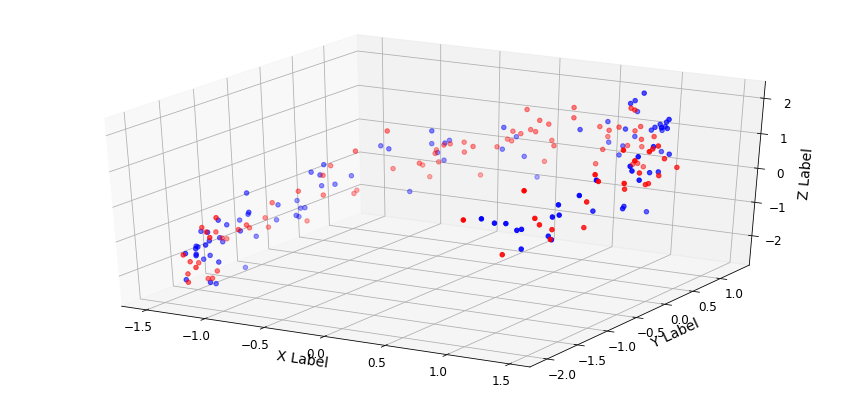

In [35]:

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111, projection='3d')

# Training data is shown as red points. 
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2], c='r', marker='o')

# Test data is shown as blue points. 
ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], c='b', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

Finally, the AE is defined. It has a structure very similar to a MLP. The main difference is in the Loss function. 
Check the details of the AE below.

In [36]:

# Since there are only three dimensions, the number of inputs is 3
n_inputs = 3

# Two neurons in the single hidden layers
n_hidden = 2  

# The number of inputs and outputs in the AE is always the same
n_outputs = n_inputs


reset_graph()
learning_rate = 0.01
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# The hidden and output layers are defined using the
# layers.dense function that does something similar to what 
# the function neuron_layer defined above does. You can see
# other parameters of this function here: https://www.tensorflow.org/api_docs/python/tf/layers/dense
hidden = tf.layers.dense(X, n_hidden, name='hidden_layer')
outputs = tf.layers.dense(hidden, n_outputs)

# The loss function is the mean-square error of the difference 
# between output and input
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

# Adam optimizer is used
optimizer = tf.train.AdamOptimizer(learning_rate)

# Minimization of the reconstruction loss 
training_op = optimizer.minimize(reconstruction_loss)

# The computation graph is initialized
init = tf.global_variables_initializer()

Finally the AE is run. We will store the output of the hidden layer  (only 2 dimensions) to inspect these values later.

In [37]:
# Number of iterations for the network
n_iterations = 1000
# Hidden layer 
codings = hidden

# We will keep the weights of the "hidden" layer in the variable "weights"
weights = tf.get_default_graph().get_tensor_by_name(os.path.split(hidden.name)[0] + '/kernel:0')

# The AE is run
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
        
    # We use the hidden layer as a function and it outputs
    # 2-dimensional representation of the input
    codings_val = codings.eval(feed_dict={X: X_test})

    # We print the weights learned by the network
    print(weights.eval())
 

[[-0.5706079   1.51454246]
 [-0.81190026 -0.33110455]
 [-0.69808847  0.26326936]]


We visualize the two dimensional representation. Notice the similarity to the original data in three  dimensions. In this example AE has shown its use as dimensionality reduction method. 

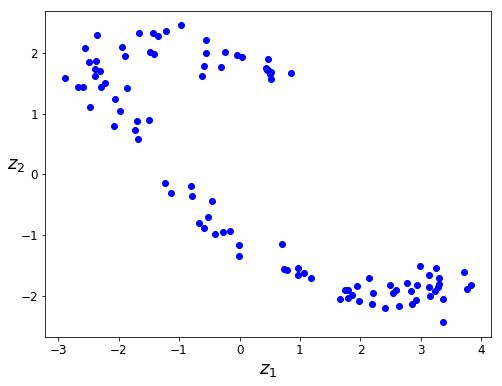

In [38]:
fig = plt.figure(figsize=(8,6))
plt.plot(codings_val[:,0], codings_val[:, 1], "bo")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

In [94]:
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


We will use a dataset of chinese characters. It contains images of around 9000 chinese characters. The original dataset from which these images have been produced is available from: https://github.com/skishore/makemeahanzi

Check that you have the folder "chinese" that contains this dataset and run the following cells. 

In [39]:
from IPython.display import SVG
#from IPython.core.display import SVG 
im = SVG(filename='chinese/13318.svg')


plt.show()

#import imageio
#im = imageio.imread('chinese/13318.svg')
#print(im.shape)
#plt.imshow(im)

chinese_char = np.load('chinese/chinese_characters.npy')
chinese_char = chinese_char.reshape((9508, 784))


## Exercise 2.

- Modify the following implementation to learn an autoencoder for the MNIST dataset
- Check the quality of the implementation running the following cells.

In [52]:
# Parameters that define the MLP

n_inputs = 28*28  
n_hidden1 = 100
n_outputs = 28*28

reset_graph()

# Variables are declared, notice that the shape of X is only partially defined
# with the number of inputs, but not the number of instances 
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
output_X = tf.placeholder(tf.float32, shape=(None, None), name="output_X")

def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        # Number of inputs
        n_inputs = int(X.get_shape()[1])
        
        # This value is computed to randomly initialize the weights
        stddev = 2 / np.sqrt(n_inputs)
        
        # Weigths can be initialized in different ways
        # Here they are randomly initialized from a Normal distribution (mean=0,std as computed before)
        # Notice that weights are organized in a matrix (tensor) and its number is n_inputs*n_neurons
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        
        # The variable that will contain the weights is W
        W = tf.Variable(init, name="kernel")
        
        # The variable that will contain the bias is b  
        # and is initialized to zero
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        
        # As in the perceptron what the neurons do is multiply the weights by 
        # the input
        Z = tf.matmul(X, W) + b
        
        # What the activation function does is to "process" the result
        # of the multiplication of weights by inputs, and this is the output
        # of every neuron. 
        
        if activation is not None:
            return activation(Z)
        else:
            return Z
        
def AE(x):
   # The scope name for this MLP is "dnn"
    with tf.name_scope("AE"):

        hidden1 = tf.layers.dense(X, n_hidden1, name='hidden_layer')

        outputs = neuron_layer(hidden1, n_outputs, name="outputs")
    
    return outputs


# The result of the autoencoder is the reconstructed image
prediction = AE(X)

# scope name of the loss function is "loss"
with tf.name_scope("loss"):   
    
    # The loss function is the mean-square error of the difference 
    # between output and input
    reconstruction_loss = tf.reduce_mean(tf.square(prediction - X))

learning_rate = 0.01

with tf.name_scope("train"):
    # The plain GradientDescentOptimizer is chosen
    optimizer = tf.train.AdamOptimizer(learning_rate) 
    training_op = optimizer.minimize(reconstruction_loss)

# Initialization of the computation graph
init = tf.global_variables_initializer()

# Number of epochs
n_epochs = 60

# Size of the batch used to update the gradient
batch_size = 100

# We will keep the weights of the "hidden" layer in the variable "weights"
#weights = tf.get_default_graph().get_tensor_by_name(os.path.split(hidden1.name)[0] + '/kernel:0')
#weights = tf.get_default_graph().get_tensor_by_name(os.path.split(outputs.name)[0] + '/kernel:0')

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            
            #Function next_batch automatically select the batch
            X_batch, y_batch = mnist.train.next_batch(batch_size)
           
        
            # Weights are learned using the current batch            
            sess.run(training_op, feed_dict={X: X_batch})
            
        rec_val = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
        print(epoch, "Reconstruction error:", rec_val)
 
    #w = weights.eval()

    pred_MNIST = sess.run(prediction,feed_dict={X: mnist.test.images})

    
    # Do not comment or remove the following lines
    pred_fashion = sess.run(prediction,feed_dict={X: fashion.validation.images})
    pred_chinese = sess.run(prediction,feed_dict={X: chinese_char})


0 Reconstruction error: 0.0126419
1 Reconstruction error: 0.008009
2 Reconstruction error: 0.00690339
3 Reconstruction error: 0.00646567
4 Reconstruction error: 0.00670894
5 Reconstruction error: 0.00669061
6 Reconstruction error: 0.010536
7 Reconstruction error: 0.00770634
8 Reconstruction error: 0.00682064
9 Reconstruction error: 0.006575
10 Reconstruction error: 0.006417
11 Reconstruction error: 0.00648929
12 Reconstruction error: 0.00625574
13 Reconstruction error: 0.00635227
14 Reconstruction error: 0.00610435
15 Reconstruction error: 0.00615541
16 Reconstruction error: 0.00595524
17 Reconstruction error: 0.00604606
18 Reconstruction error: 0.00630783
19 Reconstruction error: 0.00622993
20 Reconstruction error: 0.00662077
21 Reconstruction error: 0.00655791
22 Reconstruction error: 0.00872019
23 Reconstruction error: 0.00932782
24 Reconstruction error: 0.0073631
25 Reconstruction error: 0.00693846
26 Reconstruction error: 0.00655377
27 Reconstruction error: 0.00651607
28 Reconstru

We compare the inputs and the outputs of the network for the MNIST dataset

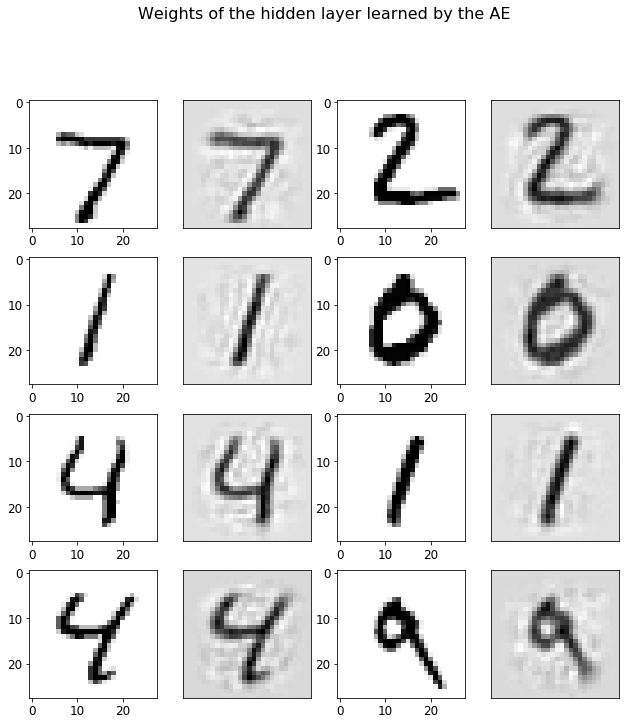

In [53]:

plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(mnist.test.images[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_MNIST[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

Although the AE was learned with the MNIST dataset we could check how good it is to reconstruct other types of images.


We compare the inputs and the outputs of the network for the fashion dataset

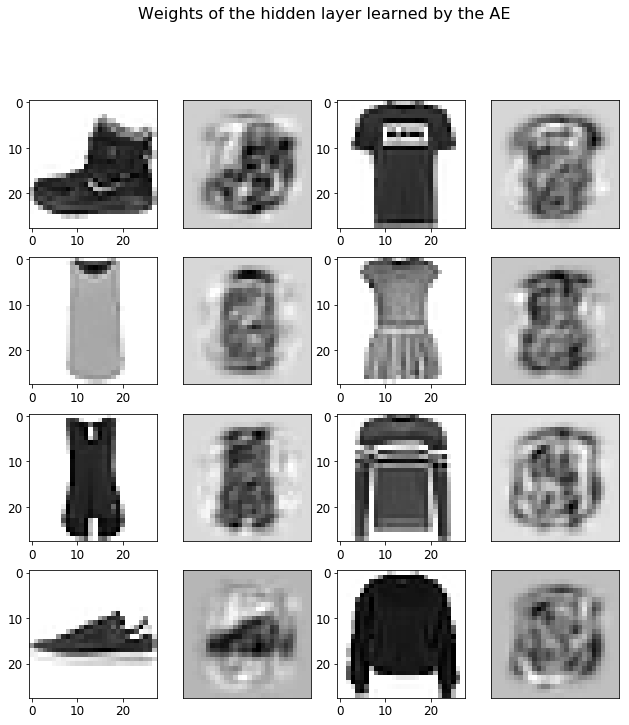

In [54]:

plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fashion.validation.images[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_fashion[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

We compare the inputs and the outputs of the network for the chinese character dataset

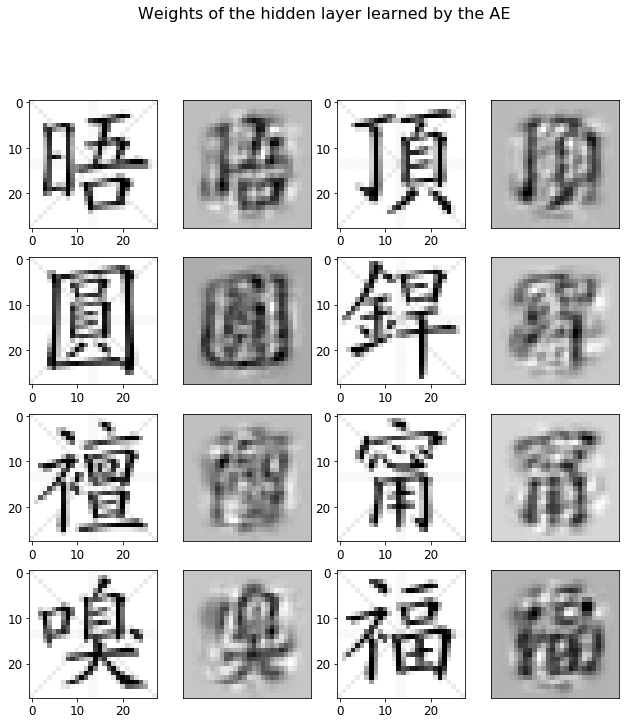

In [55]:
plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(chinese_char[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_chinese[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()




Not all datasets are equally easy to learn with an AE. Directly learning from the chinese-character dataset is more complex. You can check this by running the following cell that trains the AE using the chinese-character dataset.

Notice too that the number of instances available for learning is also an important element for learning DNNs. For the chinese-character dataset we only have a fraction of the number of instances we have for MNIST.

In [56]:
# Number of epochs
n_epochs = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        #for iteration in range(mnist.train.num_examples // batch_size):
            
            #Function next_batch automatically select the batch
            #X_batch, y_batch = mnist.train.next_batch(batch_size)
           
        
            # Weights are learned using the current batch            
            sess.run(training_op, feed_dict={X: chinese_char[0::1,:]/ 255.})
            
            rec_val = reconstruction_loss.eval(feed_dict={X: chinese_char[0::2,:]/255.})
            print(epoch, "Reconstruction error:", rec_val)
 
    #w = weights.eval()

    pred_MNIST = sess.run(prediction,feed_dict={X: mnist.validation.images})

    
    # Do not comment or remove the following lines
    pred_fashion = sess.run(prediction,feed_dict={X: fashion.validation.images})
    pred_chinese = sess.run(prediction,feed_dict={X: chinese_char})

 

0 Reconstruction error: 4.07013
1 Reconstruction error: 1.23063
2 Reconstruction error: 0.936422
3 Reconstruction error: 0.906532
4 Reconstruction error: 0.947373
5 Reconstruction error: 1.00114
6 Reconstruction error: 0.866994
7 Reconstruction error: 0.656817
8 Reconstruction error: 0.515708
9 Reconstruction error: 0.432285
10 Reconstruction error: 0.387034
11 Reconstruction error: 0.357477
12 Reconstruction error: 0.327659
13 Reconstruction error: 0.299434
14 Reconstruction error: 0.274757
15 Reconstruction error: 0.257136
16 Reconstruction error: 0.244213
17 Reconstruction error: 0.239571
18 Reconstruction error: 0.245134
19 Reconstruction error: 0.248901
20 Reconstruction error: 0.247886
21 Reconstruction error: 0.243797
22 Reconstruction error: 0.230198
23 Reconstruction error: 0.211122
24 Reconstruction error: 0.194987
25 Reconstruction error: 0.18205
26 Reconstruction error: 0.172451
27 Reconstruction error: 0.16929
28 Reconstruction error: 0.16782
29 Reconstruction error: 0.166

Run the following cell to see how good is the AE reconstructing the chinese characters. 

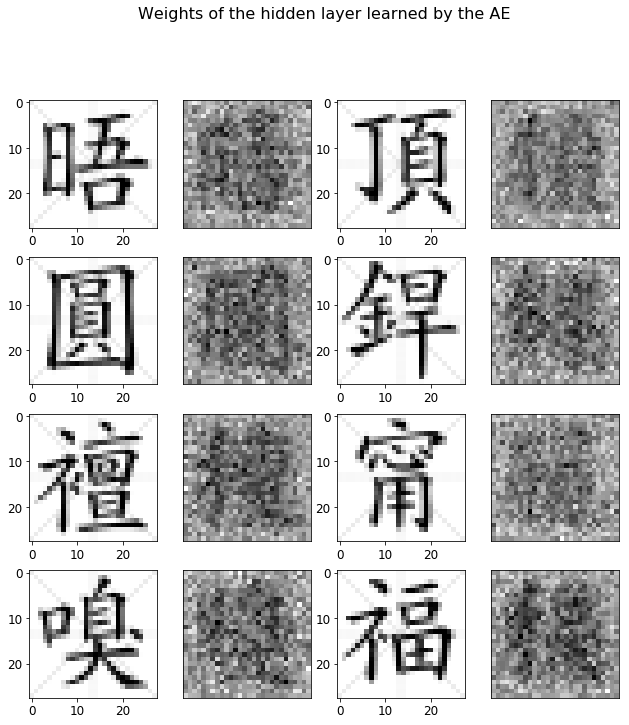

In [57]:
plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(chinese_char[int(i/2),:].reshape((28, 28))/.255, cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_chinese[int(i/2),:].reshape((28, 28))/.255, cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

Run the following cell to see how good is the AE reconstructing the fashion dataset. 

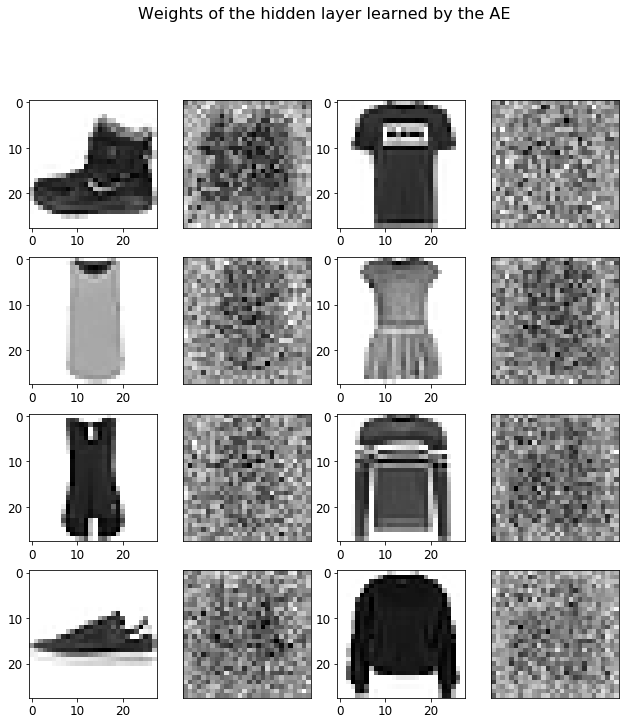

In [58]:
plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fashion.validation.images[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_fashion[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

## Denoising autoencoder


Denoising autoencoders (DAE) are very similar to AEs but they are trained to recover a "corrupted" input. This means that some noise will added to the input for training, but the corresponding output will be kept without any noise.

In the example below, we add some noise to the MNIST datasets, create a denoising autoencoder that is overcomplete, and evaluate its behavior to denoise other images. 

The key point in this DAE implementation is that the noise is added to the input by the own network. 

In [59]:
import sys

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 100
n_outputs = n_inputs
learning_rate = 0.01


# The noise level is defined
noise_level = 1

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# The noise is added to input
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))


def DAE(x):
    # The scope name for this MLP is "dnn"
    with tf.name_scope("DAE"):
        hidden1 = tf.layers.dense(x, n_hidden1, activation=tf.nn.relu, name="hidden1")

        outputs = tf.layers.dense(hidden1, n_outputs, name="outputs")      
    
    return outputs


# The result of the autoencoder is the reconstructed image
prediction = DAE(X_noisy)
    
#prediction_no_noisy = DAE(X)    

reconstruction_loss = tf.reduce_mean(tf.square(prediction - X)) 


optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()



n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)

    pred_MNIST = sess.run(prediction,feed_dict={X: mnist.test.images})

    
    # Do not comment or remove the following lines
    pred_fashion = sess.run(prediction,feed_dict={X: fashion.validation.images})
    pred_chinese = sess.run(prediction,feed_dict={X: chinese_char})

0 Train MSE: 0.0577947
1 Train MSE: 0.0499873
2 Train MSE: 0.049314
3 Train MSE: 0.0820957
4 Train MSE: 0.0751353
5 Train MSE: 0.0629969
6 Train MSE: 0.0670845
7 Train MSE: 0.0637088
8 Train MSE: 0.0781321
9 Train MSE: 0.198631


We compare the predictions of the network for MNIST

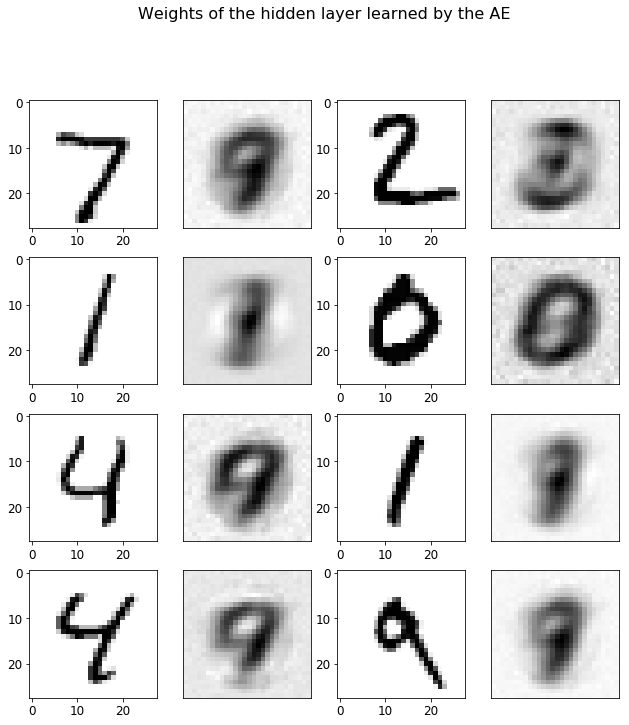

In [60]:
plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(mnist.test.images[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_MNIST[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()


We compare the predictions of the network for the fashion dataset

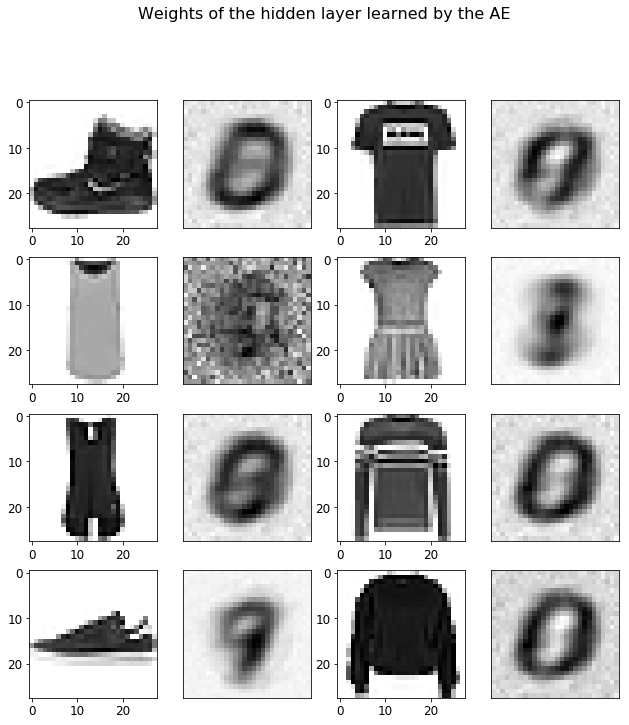

In [61]:
plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fashion.validation.images[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_fashion[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

We compare the predictions of the network for the fashion dataset

## Exercise 3

- Create a denoising autoencoder for the chinese_char dataset.
- It should have three hidden layers and use the AdamOptimizer.
- The first and the last hidden layers should have the same number of neurons. 


In [62]:
import sys

reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_hidden3 = 300
n_outputs = n_inputs
learning_rate = 0.01


# The noise level is defined
noise_level = 1

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# The noise is added to input
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

def DAE(x):
    # The scope name for this MLP is "dnn"
    with tf.name_scope("DAE"):
        hidden1 = tf.layers.dense(x, n_hidden1, activation=tf.nn.relu,  name="hidden1")
        hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,  name="hidden2")
        hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu,  name="hidden3")
                
        outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")      
    
    return outputs


# The result of the autoencoder is the reconstructed image
prediction = DAE(X_noisy)
    
#prediction_no_noisy = DAE(X)    
reconstruction_loss = tf.reduce_mean(tf.square(prediction - X)) 

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()  

To test your implementation you may use the following two cells


In [63]:
n_epochs = 501
when_display = 25

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        # Using even instances to learn
        X_batch = chinese_char[0::2,:] 
        sess.run(training_op, feed_dict={X: X_batch})
        
        # Using odd instances to evaluate loss
        loss_train = reconstruction_loss.eval(feed_dict={X: chinese_char[1::2,:]})
        if epoch % when_display == 0:
           print("\r{}".format(epoch), "Train MSE:", loss_train)

    pred_chinese = sess.run(prediction,feed_dict={X: chinese_char})
    

0 Train MSE: 20436.3
25 Train MSE: 4830.87
50 Train MSE: 4611.58
75 Train MSE: 4413.33
100 Train MSE: 4372.75
125 Train MSE: 4334.3
150 Train MSE: 4303.98
175 Train MSE: 4285.74
200 Train MSE: 4250.76
225 Train MSE: 4216.23
250 Train MSE: 4178.79
275 Train MSE: 4174.89
300 Train MSE: 4147.51
325 Train MSE: 4127.96
350 Train MSE: 4107.25
375 Train MSE: 4101.39
400 Train MSE: 4109.38
425 Train MSE: 4072.91
450 Train MSE: 4061.74
475 Train MSE: 4065.29
500 Train MSE: 4049.96


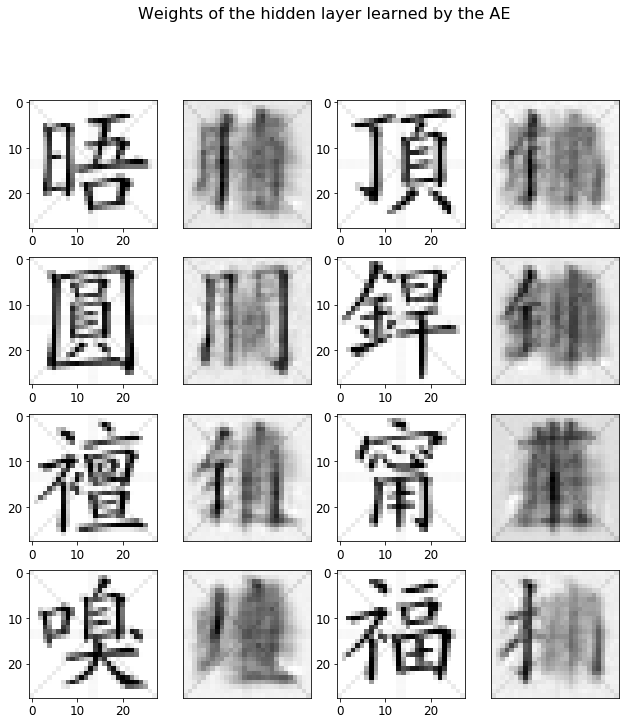

In [64]:
plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(chinese_char[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_chinese[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

## Sparse Autoencoder

Sparse autoencoders attempt to reduce the number of active neurons in the hidden (coding) layers. The idea is to force the AE  to represent each input as a combination of a reduced number of neurons. It is expected that such coding neurons will likely be more informative about the inputs. 

First, we need to define a way to measure the sparsity of the coding layer. This is done by computing the average activation of the neurons in the layer considering the complete training batch. 

Once this value has been defined, we need to penalize neurons that are too active. For doing this, a target sparsity value is defined (it is a hyperparameter of the AE) and a sparsity loss function is defined to penalize the deviation from from the target sparsity. In the example below we used the Kullback-Leibler divergence between two distributions. This measure was explained in Lecture 3 (Mathematical background).

[0, 1, 0, 0.95]

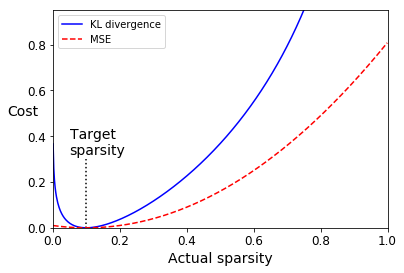

In [65]:
# Visualization of the KL divergence where the Target Sparsity is 0.1
# The graph also shows the square difference which could be an alternative
# sparsity loss measure


p = 0.1
q = np.linspace(0.001, 0.999, 500)

# Computation of the KL metric
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2



plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])


Below we define the code for learning a Sparsity AE (SAE).

To learn a SAE, we need that learning algorithm balance two tasks: 1) Get a low reconstruction error. 2) To be as close to the sparsity target as possible. To balance these two objectives, a sparsity_weight hyper-parameter is defined. It represents how much weight should be given to the sparsity loss criterion in coparison with the reconstruction loss criterion. 

In [66]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000     # sparse codings
n_outputs = n_inputs

# Definition of the KL divergence using tensorflow
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))


# This is the learning rate of the optimizer
learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

def SAE(x):
    # The scope name for this MLP is "dnn"
    with tf.name_scope("SAE"):
        
        
        h1 = tf.layers.dense(x, n_hidden1, activation=tf.nn.sigmoid) 
        outputs = tf.layers.dense(h1, n_outputs)                    

    
    return outputs, h1

prediction, hidden1 = SAE(X)

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(prediction - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss



optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
init = tf.global_variables_initializer()


n_epochs = 10
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)

    pred_MNIST = sess.run(prediction,feed_dict={X: mnist.test.images})
    pred_fashion  = sess.run(prediction,feed_dict={X: fashion.validation.images})
    pred_chinese = sess.run(prediction,feed_dict={X: chinese_char})
    



0 Train MSE: 0.125037 	Sparsity loss: 0.365025 	Total loss: 0.198043
1 Train MSE: 0.060347 	Sparsity loss: 0.0577325 	Total loss: 0.0718935
2 Train MSE: 0.0514458 	Sparsity loss: 0.0330063 	Total loss: 0.0580471
38% Train MSE: 0.0473442 	Sparsity loss: 0.00668051 	Total loss: 0.0486803
4 Train MSE: 0.0457203 	Sparsity loss: 0.153108 	Total loss: 0.076342
5 Train MSE: 0.0418575 	Sparsity loss: 0.0242129 	Total loss: 0.0467001
6 Train MSE: 0.038323 	Sparsity loss: 0.109667 	Total loss: 0.0602564
7 Train MSE: 0.0361453 	Sparsity loss: 0.0377574 	Total loss: 0.0436968
8 Train MSE: 0.0333411 	Sparsity loss: 0.0755855 	Total loss: 0.0484582
9 Train MSE: 0.0285804 	Sparsity loss: 0.169037 	Total loss: 0.0623878


(10000, 1000)


In [67]:
Display the reconstructions for the autoencoder on MNIST

SyntaxError: invalid syntax (<ipython-input-67-85bda9cc2e5a>, line 1)

In [ ]:
plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(mnist.test.images[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_MNIST[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()


Display the reconstructions for the autoencoder on fashion dataset

In [ ]:
plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fashion.validation.images[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_fashion[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

Display the reconstructions for the autoencoder on chinese-char dataset

In [ ]:
plt.figure(figsize=(10,10))
for i in np.arange(0,16,2):
    plt.subplot(4, 4, i + 1)
    plt.imshow(chinese_char[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    plt.subplot(4, 4, i + 2)
    plt.imshow(pred_chinese[int(i/2),:].reshape((28, 28)), cmap=plt.cm.gray_r,interpolation='nearest')
    
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Weights of the hidden layer learned by the AE', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()

## Exercise 4

- Create a SAE for the fashion dataset 
- Use the representation learned (the coding layer) for implementing a supervised MLP to classify which of the 10 classes each instance belongs to.
- Create a pipeline in sklearn that starts from the coding layer representation, makes a selection of the 500 most relevant variables and applies a random forest. Compare the accuracy to the one obtained by the MLP.

Suggestion 1: You may use sklearn MLP implementation or the tensorflow implementation (or both)

Suggestion 2: To extract the features you may use function SAE(X)